# Predict rating based on review of the food product

### Data Source:

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

### Basic Imports

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import re
import seaborn as sns

Lets load the data to see what all information we can get

### Load the data:

Here we see that data is available in two formats : 
1. Reviews.csv
2. database.sqlite


** Lets first load our data using csv format **

In [193]:
table=pd.read_csv('Reviews.csv')

In [194]:
table.shape

(568454, 10)

In [195]:
table.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


As we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "postive". Otherwise, it will be set to "negative".

Above we can see that the **Time** column values is in unix time.
Unix time (also known as POSIX time or UNIX Epoch time) is a system for describing a point in time, defined as the number of seconds that have elapsed since 00:00:00 Coordinated Universal Time (UTC), Thursday, 1 January 1970. Every day is treated as if it contains exactly 86400 seconds, so leap seconds are not applied to seconds since the Epoch.

Lets convert the unix time in to year-month-date format using the below function

In [5]:
import datetime
def timestmp(time):
    timestamp = datetime.datetime.fromtimestamp(time)
    return timestamp.strftime('%Y-%m-%d')
    
time=table['Time']
tm=time.map(timestmp)
table['Time']=tm

table.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
table['Time'].min() # the first day when the review was recorded

'1999-10-08'

In [7]:
table['Time'].max() # the last day on which the review is recorded

'2012-10-26'

In [8]:
table.shape # more than 500k reviews

(568454, 10)

In [9]:
table['UserId'].describe() # number of customers

count             568454
unique            256059
top       A3OXHLG6DIBRW8
freq                 448
Name: UserId, dtype: object

In [10]:
table['ProductId'].describe() # No of food items

count         568454
unique         74258
top       B007JFMH8M
freq             913
Name: ProductId, dtype: object

### Attribute Information

Number of Attributes/Columns in data: 10
1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

### Objective:

The purpose of this analysis is to make up a prediction model where we will be able to predict whether a review is positive or negative. We will use Score/Rating of the product to say whether a review is positive or negative.
For score > 3 polarity(sentiment) of the review is positive and score < 3 polarity of review is negative. We will ignore all the reviews whose score = 3.

** Lets drop those rows whose Score = 3**

In [11]:
table.drop(table[table["Score"]==3].index,inplace=True)

In [12]:
table[table.Score==3] # No rows where Score=3 hence we will now convert Score as positive or negative

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


**  Converting Score > 3 as positive and Score < 3 as negative **

In [13]:
def polarity(score):
    if score > 3:
        return 'positive'
    else :
        return 'negative'
score=table['Score']
table['Score']=score.map(polarity)

In [14]:
table.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...


# 1) Exploratory Data Analysis

### 1.1)Removing Duplicates

** The dataset has many duplicate entries . It is necessary to remove duplicate values in order to get unbiased results **

In [15]:
table[table["UserId"]=="AR5J8UI46CURR"]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
73790,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,positive,2008-01-06,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
78444,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,positive,2008-01-06,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
138276,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,positive,2008-01-06,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
138316,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,positive,2008-01-06,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
155048,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,positive,2008-01-06,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

** Lets clear such duplicates by ordering them according to Product ID**

In [16]:
sort=table.sort_values('ProductId',axis=0,inplace=False)

In [17]:
data=table.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},inplace=False,keep='first')

In [18]:
data[data['Score']== np.NaN]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


** Lets see the data left after dropping the duplicates**

In [19]:
table.shape

(525814, 10)

In [20]:
data.shape

(364173, 10)

** Percentage of data remaining**

In [21]:
print(str(data.shape[0]/table.shape[0]*100) + ' %')

69.25890143662969 %





** Let's observe the HelpfulnessNumerator and HelpfulnessDenominator columns**

HelpfulnessNumerator-Number of people who found the review helpful<br>
HelpfulnessDenominator-Number of people who indicated wether the review was helpfull or not<br>
Practically HelpfulnessDenominator >= HelpfulnessNumerator <br>
But we see that in some observations(rows) its not true

In [22]:
data[data['HelpfulnessNumerator']>data['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,positive,2008-06-08,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,positive,2008-10-25,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [23]:
data=data[data.HelpfulnessNumerator<=data.HelpfulnessDenominator]

In [24]:
data1=data.sort_values("Time",axis=0)

In [25]:
data1.reset_index(inplace=True,drop=True)

In [26]:
data1.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
3,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
4,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


# 2)Text-Preprocessing

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

### 2.1) Removing html tags

In [27]:
import re

def remove_tags(text):
    com=re.compile("<.*?>")
    clean=re.sub(com,'',text)
    return clean

text1 = """<div>
<h1>Title</h1>
<p>A long text........ </p>
<a href=""> a link </a>
</div>"""
print(remove_tags(text1))


Title
A long text........ 
 a link 



### 2.2) Remove punctuations and special characters**

In [28]:
def remove_punct(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

In [29]:
data['Text'].head(10)

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
5    I got a wild hair for taffy and ordered this f...
6    This saltwater taffy had great flavors and was...
7    This taffy is so good.  It is very soft and ch...
8    Right now I'm mostly just sprouting this so my...
9    This is a very healthy dog food. Good for thei...
Name: Text, dtype: object

### 2.3) Stop-words

One of the most common text-preprocessing steps is removal of stop words.<br>
Stop words are words which are filtered out before or after processing of natural language data (text).<br>
Such as "the","is","this" etc.

In [30]:
from nltk.corpus import stopwords # gets all the stopwords which nltk think are stop words

# lets see some common stop words in english
stop=set(stopwords.words('english'))

print(stop)

{"don't", 'couldn', 'mustn', 'ma', 'but', 'out', 'because', 'where', 'each', 'not', 'those', 'and', 'so', 'in', "mightn't", 'above', 'than', 'my', 'm', 't', 'both', "won't", 'yours', 'yourself', "shan't", 'yourselves', 'or', 's', "couldn't", 'at', 'doing', "wasn't", 'nor', 'into', 'i', 'they', 'd', 'll', 'its', 'during', 'very', 'an', 'am', 'by', 'when', 're', 'haven', 'about', 'needn', 'been', 'off', "she's", 'o', 'shan', 'before', 'me', 'ain', 'more', 'such', 'he', 'a', 'which', "should've", 'myself', 'are', 'shouldn', 'ourselves', 'we', 'our', "you're", "that'll", 'over', 'down', 'the', 'themselves', 'don', 'whom', 'after', 'herself', 'what', 'there', "you'll", 'himself', 'theirs', 'up', 'some', 'their', 'these', 'no', 'if', "you've", 'should', 'isn', 'itself', 'now', 'same', 'has', 'for', 'it', 'wasn', 'that', 'didn', "needn't", "shouldn't", 'do', 'having', 'with', 'just', 'ours', "you'd", 'to', 'weren', 'were', 'until', 'you', 'be', 'from', 'hasn', 'hers', 'of', 'all', "weren't", 

Above you can see python considers "not" as a stop word which completely changes the semantic meaning of sentences , hence removing stop words might be dangerous sometimes.

### 2.4) Stemming

**Stemming**:is to find the root word or the root form of any given word.<br>
By stemming we replace the words which have same step or root words this reduces words in our corpus and hence the dimensions of vector.<br>
Doing stemming is non trivial.<br>
Stemming is all about taking words which are related and convert them to thier root form.


There are multiple algorithm to do stemming 
 1. Porter Stemmer
 2. SnowBall Stemmer

In [31]:
from nltk.stem import SnowballStemmer
sno=SnowballStemmer('english')

#### 2.4.1) Let's check word root of few words **

In [32]:
# lets check the root word of few words
print(sno.stem('Tasty'))
print(sno.stem('Tasteful'))
print(sno.stem('Tastefully'))
print(sno.stem('Tasteless'))
print(sno.stem('Beautiful'))
print(sno.stem('delicious'))
print(sno.stem('computer'))
print(sno.stem('compute'))


tasti
tast
tast
tasteless
beauti
delici
comput
comput


### Preprocessing of data

In [33]:
data1.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
3,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
4,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


In [34]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in data1['Text'].values:
    
    
    filtered_sentence=[]
    #print(sent);
    sent=remove_tags(sent) # remove HTMl tags
    sent=remove_punct(sent).split()
    for cleaned_words in sent:
        if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
            if(cleaned_words.lower() not in stop):
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence.append(s)
                if (data1['Score'].values)[i] == 'positive': 
                    all_positive_words.append(s) #list of all words used to describe positive reviews
                if(data1['Score'].values)[i] == 'negative':
                    all_negative_words.append(s) #list of all words used to describe negative reviews reviews
            else:
                continue
        else:
            continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")

    final_string.append(str1)
    i+=1

In [35]:
(data['Score'].values)[0]

'positive'

In [36]:
final_string

[b'witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg',
 b'rememb see show air televis year ago child sister later bought day thirti someth use seri book song student teach preschool turn whole school purchas along book children tradit live',
 b'beetlejuic well written movi everyth excel act special effect delight chose view movi',
 b'twist rumplestiskin captur film star michael keaton geena davi prime tim burton masterpiec rumbl absurd wonder pace point dull moment',
 b'beetlejuic excel funni movi keaton hilari wacki beetlejuic great special effect help film think one best movi ever made sure youll agre good time watch beetlejuic',
 b'one movi movi collect fill comedi action whatev els want call',
 b'alway enjoy movi funni entertain didnt hesit pick clamshel edit guess market plan make movi famili someth elimin strong profan element usual edi

**Adding a column of CleanedText which displays the data after pre-processing of the review **

In [37]:
data1['Cleaned Text']=final_string

In [38]:
data1.shape

(364171, 11)

In [39]:
data1.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned Text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
3,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
4,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


In [40]:
data1[data1['Score']==np.NaN]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned Text


# Converting text to vector

## Using Bag Of Words

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

vec=CountVectorizer()

let's see how bag of words work

In [42]:
text=['the quick quick quick brown fox jump over the lazy dog']

vec=vec.fit(text)

vector=vec.fit_transform(text)

vec.vocabulary_

{'brown': 0,
 'dog': 1,
 'fox': 2,
 'jump': 3,
 'lazy': 4,
 'over': 5,
 'quick': 6,
 'the': 7}

In [43]:
vector.shape

(1, 8)

In [44]:
print(vector)

vec=vec.fit_transform(data1['Text'].values)

  (0, 1)	1
  (0, 4)	1
  (0, 5)	1
  (0, 3)	1
  (0, 2)	1
  (0, 0)	1
  (0, 6)	3
  (0, 7)	2


In [45]:
vec.shape

(364171, 115281)

In [46]:
type(vec)

scipy.sparse.csr.csr_matrix

** Lets check the frequency distribution of negative and positive words**

In [47]:
from nltk import FreqDist

In [48]:
freq_positive_words=FreqDist(all_positive_words)
freq_negative_words=FreqDist(all_negative_words)

In [49]:
print("Most Common Positive Words ",freq_positive_words.most_common(20))

Most Common Positive Words  [(b'like', 139247), (b'tast', 128584), (b'good', 112218), (b'flavor', 109231), (b'love', 107174), (b'use', 103710), (b'great', 103253), (b'one', 96403), (b'product', 90673), (b'tri', 86561), (b'tea', 83602), (b'coffe', 78510), (b'make', 74973), (b'get', 72011), (b'food', 64605), (b'would', 55476), (b'time', 55072), (b'buy', 54068), (b'realli', 52626), (b'eat', 51885)]


In [50]:
print("Most Common Positive Words ",freq_negative_words.most_common(20))

Most Common Positive Words  [(b'tast', 34503), (b'like', 32298), (b'product', 28114), (b'one', 20501), (b'flavor', 19493), (b'would', 17956), (b'tri', 17722), (b'use', 15280), (b'good', 14988), (b'coffe', 14642), (b'get', 13770), (b'buy', 13719), (b'order', 12846), (b'food', 12706), (b'dont', 11835), (b'tea', 11619), (b'even', 11060), (b'box', 10802), (b'amazon', 10017), (b'make', 9825)]


<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

# Bi-grams and n-grams

In [51]:
count_vect=CountVectorizer(binary=True) # converting it into bi grams
final_bigram_count=count_vect.fit_transform(data1['Cleaned Text'].values)

** Let's see the shape of the final bi grams**

In [52]:
final_bigram_count.shape

(364171, 98496)

In [53]:
DATA=final_bigram_count[:10000].toarray()

In [54]:
col=count_vect.vocabulary_.keys()

In [55]:
count_vect.vocabulary_

{'witti': 95785,
 'littl': 49617,
 'book': 10052,
 'make': 51320,
 'son': 78918,
 'laugh': 48221,
 'loud': 50344,
 'recit': 70222,
 'car': 13419,
 'drive': 25913,
 'along': 2345,
 'alway': 2585,
 'sing': 77217,
 'refrain': 70663,
 'hes': 40147,
 'learn': 48448,
 'whale': 94655,
 'india': 42914,
 'droop': 25959,
 'love': 50387,
 'new': 57572,
 'word': 96135,
 'introduc': 43927,
 'silli': 77037,
 'classic': 16864,
 'will': 95343,
 'bet': 8382,
 'still': 81039,
 'abl': 130,
 'memori': 53169,
 'colleg': 17850,
 'rememb': 71074,
 'see': 75161,
 'show': 76702,
 'air': 1699,
 'televis': 84841,
 'year': 97024,
 'ago': 1540,
 'child': 15615,
 'sister': 77312,
 'later': 48158,
 'bought': 10363,
 'day': 21889,
 'thirti': 86641,
 'someth': 78833,
 'use': 91653,
 'seri': 75605,
 'song': 78929,
 'student': 81673,
 'teach': 84521,
 'preschool': 66908,
 'turn': 89681,
 'whole': 95077,
 'school': 74589,
 'purchas': 68537,
 'children': 15633,
 'tradit': 88585,
 'live': 49666,
 'beetlejuic': 7747,
 'well

In [56]:
score=data1['Score']

In [57]:
def change(value):
    if value=='positive':
        return 1
    else:
        return 0

In [58]:
y=list(map(change,score))

In [59]:
count=0
c=0
for i in y:
    if(i==1):
        count+=1
    else:
        c+=1
print(count)
print(c)

307061
57110


# Applying Naive Bayes

## 1) Using Bag -OF-Words

### 1.1) 1-gram

In [137]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix,average_precision_score

In [185]:
count_vect1=CountVectorizer(binary=True) # converting it into bi grams
final_bigram_count=count_vect1.fit_transform(data1['Cleaned Text'].values)

In [186]:
final_bigram_count.shape

(364171, 98496)

In [199]:
X_1,X_test,y_1,y_test=train_test_split(final_bigram_count,y, random_state=0,test_size=0.1)

X_train,X_cv,y_train,y_cv=train_test_split(X_1,y_1,random_state=0,test_size=0.1)

### 1.1.1)  Finding Alpha Using Normal Cross-Validation

In [188]:
scr=[]
alpha=[10**a for a in range(-5,4)]
for i in range(-5,4):
    clf1=BernoulliNB(alpha=10**i)
    clf1.fit(X_train,y_train)
    
    pred=clf1.predict(X_cv)
    score=accuracy_score(y_cv,pred)*float(100)
    scr.append(score)
    print("Accuracy score for alpha=10^{} is {}".format(i,score))

Accuracy score for alpha=10^-5 is 88.72955821332683
Accuracy score for alpha=10^-4 is 88.80583353673418
Accuracy score for alpha=10^-3 is 88.86685379546009
Accuracy score for alpha=10^-2 is 88.86380278252379
Accuracy score for alpha=10^-1 is 88.67463998047351
Accuracy score for alpha=10^0 is 88.11935562606786
Accuracy score for alpha=10^1 is 84.43678301195997
Accuracy score for alpha=10^2 is 84.11337564071272
Accuracy score for alpha=10^3 is 84.13168171833048


In [189]:
clf1=BernoulliNB(10**-3)
clf1.fit(X_1,y_1)

y_pred=clf1.predict(X_test)
score=accuracy_score(y_test,y_pred)*float(100)
print("Accuracy score for alpha=10^{} is {}".format(-3,score))

Accuracy score for alpha=10^-3 is 88.50842989730353


In [190]:
tn, fp, fn, tp=confusion_matrix(y_test, y_pred).ravel()

tpr=tp/(tp+fn)
fpr=fp/(fp+tn)
tnr=tn/(tn+fp)
fnr=fn/(fn+tp)
print("TPR is {}\n FPR is {}\n TNR is {}\n FNR is {}".format(tpr*100,fpr*100,tnr*100,fnr*100))


TPR is 93.12862637720842
 FPR is 36.184668989547035
 TNR is 63.81533101045296
 FNR is 6.871373622791577


In [191]:
neg_class_prob_sorted = clf1.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = clf1.feature_log_prob_[1, :].argsort()

print(np.take(count_vect1.get_feature_names(), neg_class_prob_sorted[:10]))
print(np.take(count_vect1.get_feature_names(), pos_class_prob_sorted[:10]))

['aa' 'nutsbut' 'nutsand' 'nutsa' 'nutrut' 'nutruit' 'nutrtit' 'nutrtious'
 'nutromax' 'nutroa']
['easyset' 'swheatlitt' 'buttonwood' 'buttpain' 'reimagin' 'ooba' 'ooam'
 'swerdlow' 'swepp' 'swenson']


### 1.1.2) Finding Best Alpha using k fold cross validation

In [147]:
alpha=[10**a for a in range(-5,4)]

In [148]:
sc=[]
for a in range(-5,4):
    clf1=BernoulliNB(alpha=10**a)
    clf1.fit(X_1,y_1) # Using Train set of 90% data points
    scores = cross_val_score(clf1, X_1, y_1, cv=10, scoring='accuracy')
    sc.append(scores.mean())
    print("Accuracy score for alpha=10^{} is {}\n".format(a,scores.mean()*100))

Accuracy score for alpha=10^-5 is 88.69301028994258

Accuracy score for alpha=10^-4 is 88.76532076734908

Accuracy score for alpha=10^-3 is 88.80040826323219

Accuracy score for alpha=10^-2 is 88.80681566035837

Accuracy score for alpha=10^-1 is 88.64754967588982

Accuracy score for alpha=10^0 is 88.19476977721973

Accuracy score for alpha=10^1 is 84.70769220171333

Accuracy score for alpha=10^2 is 84.31898406808054

Accuracy score for alpha=10^3 is 84.3266118052185



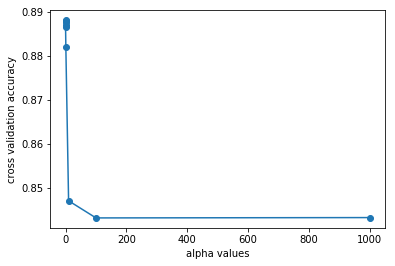

In [149]:
plt.plot(alpha,sc,'-o')
plt.xlabel('alpha values')
plt.ylabel('cross validation accuracy')
plt.show()

In [150]:
clf1=BernoulliNB(alpha=10**-2)

clf1.fit(X_1,y_1)

y_pred=clf1.predict(X_test)
print(accuracy_score(y_test,y_pred))
confusion_matrix(y_test, y_pred)

0.886429787468


array([[ 3756,  1984],
       [ 2152, 28526]], dtype=int64)

In [151]:
tn, fp, fn, tp=confusion_matrix(y_test, y_pred).ravel()

tpr=tp/(tp+fn)
fpr=fp/(fp+tn)
tnr=tn/(tn+fp)
fnr=fn/(fn+tp)
print("TPR is {}\n FPR is {}\n TNR is {}\n FNR is {}".format(tpr*100,fpr*100,tnr*100,fnr*100))

TPR is 92.98520112132472
 FPR is 34.56445993031359
 TNR is 65.43554006968641
 FNR is 7.014798878675273


### 1.1.3) Find best Alpha Using GridSearchCV

In [196]:
from sklearn.model_selection import GridSearchCV

In [197]:
tuned_parameters=[{'alpha':[10**a for a in range(-5,4)]}]

In [198]:
clf1=GridSearchCV(BernoulliNB(),tuned_parameters,cv=10,scoring='accuracy')

In [200]:
clf1.fit(X_1,y_1)

GridSearchCV(cv=10, error_score='raise',
       estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [201]:
print(clf1.best_estimator_)
print(clf1.score(X_test, y_test))

BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)
0.886429787468


### 1.2) Applying Bi-grams

In [233]:
count_vect=CountVectorizer(ngram_range=(1,2),binary=True) # converting it into bi grams
final_bigram_count=count_vect.fit_transform(data1['Cleaned Text'].values)

In [234]:
final_bigram_count.shape

(364171, 3003626)

In [235]:
X_1,X_test,y_1,y_test=train_test_split(final_bigram_count,y, random_state=0,test_size=0.1)

X_train,X_cv,y_train,y_cv=train_test_split(X_1,y_1,random_state=0,test_size=0.1)

### 1.2.1)  Finding Best Alpha Using Normal Cross-Validation

In [209]:
acc=[]
for a in range(-5,4):
    clf2=BernoulliNB(alpha=10**a)
    clf2.fit(X_train,y_train)
    
    pred=clf2.predict(X_cv)
    score=accuracy_score(y_cv,pred)*float(100)
    acc.append(score)
    print("Accuracy score for alpha=10^{} is {}".format(a,score))

Accuracy score for alpha=10^-5 is 88.78752745911642
Accuracy score for alpha=10^-4 is 89.41298511105687
Accuracy score for alpha=10^-3 is 90.19099340981207
Accuracy score for alpha=10^-2 is 90.18489138393947
Accuracy score for alpha=10^-1 is 87.69526482792287
Accuracy score for alpha=10^0 is 83.93336587747132
Accuracy score for alpha=10^1 is 84.08896753722236
Accuracy score for alpha=10^2 is 84.13168171833048
Accuracy score for alpha=10^3 is 84.13168171833048


In [210]:
alpha=[10**a for a in range(-5,4)]
ap=range(-5,4)

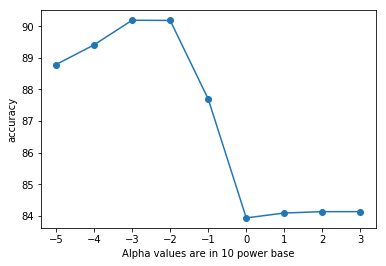

In [211]:
plt.plot(ap,acc,'-o')
plt.xlabel("Alpha values are in 10 power base")
plt.ylabel('accuracy')
plt.show()


In [213]:
clf2=BernoulliNB(10**-3)
clf2.fit(X_1,y_1)

y_pred=clf2.predict(X_test)
score=accuracy_score(y_test,y_pred)*float(100)
ps=average_precision_score(y_test,y_pred)*float(100)
print("Accuracy score for alpha=10^-3 is {}".format(score))
confusion_matrix(y_test,y_pred)

Accuracy score for alpha=10^-3 is 90.58707232687134


array([[ 3330,  2410],
       [ 1018, 29660]], dtype=int64)

In [183]:
tn, fp, fn, tp=confusion_matrix(y_test, y_pred).ravel()

tpr=tp/(tp+fn)
fpr=fp/(fp+tn)
tnr=tn/(tn+fp)
fnr=fn/(fn+tp)
print("TPR is {}\n FPR is {}\n TNR is {}\n FNR is {}".format(tpr*100,fpr*100,tnr*100,fnr*100))

TPR is 96.68166112523633
 FPR is 41.98606271777003
 TNR is 58.01393728222997
 FNR is 3.3183388747636746


In [184]:
neg_class_prob_sorted = clf2.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = clf2.feature_log_prob_[1, :].argsort()

print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:10]))
print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:10]))

['aa' 'order freshestcrack' 'order freshpak' 'order friday' 'order friel'
 'order friske' 'order fro' 'order fromamazon' 'order fromcoffeewiz'
 'order frome']
['deliveri soozi' 'remov think' 'dilig monitor' 'remov therefor'
 'dilig open' 'remov term' 'dilig pour' 'dilig purchas' 'remov tend'
 'remov tell']


### 1.2.2) Finding Best Alpha using K-fold cross validation

Accuracy score for alpha=10^-5 is 88.90994079126567

Accuracy score for alpha=10^-4 is 89.59521307939224

Accuracy score for alpha=10^-3 is 90.34486235486628

Accuracy score for alpha=10^-2 is 90.39032335058657

Accuracy score for alpha=10^-1 is 87.89789876203812

Accuracy score for alpha=10^0 is 84.15422560869918

Accuracy score for alpha=10^1 is 84.29762654931415

Accuracy score for alpha=10^2 is 84.3266118052185

Accuracy score for alpha=10^3 is 84.3266118052185



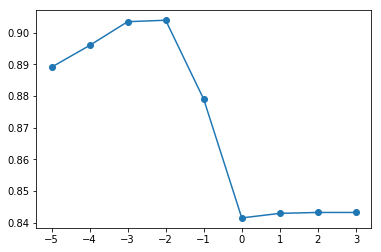

In [236]:
cvscore=[]
for a in range(-5,4):
    clf2=BernoulliNB(alpha=10**a)
    clf2.fit(X_1,y_1) # Using Train set of 90% data points
    scores = cross_val_score(clf2, X_1, y_1, cv=10, scoring='accuracy')
    cvscore.append(scores.mean())
    print("Accuracy score for alpha=10^{} is {}\n".format(a,scores.mean()*100))  
plt.plot(range(-5,4),cvscore,'-o')
plt.show()

### 1.2.3) Using GridSearchCV

In [238]:
clf2=GridSearchCV(BernoulliNB(),tuned_parameters,scoring='accuracy',cv=10)
clf2.fit(X_1,y_1)

GridSearchCV(cv=10, error_score='raise',
       estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [239]:
print(clf2.best_estimator_)
print(clf2.score(X_test, y_test))

BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)
0.904223186336


In [240]:
clf2=GridSearchCV(BernoulliNB(),tuned_parameters,scoring='accuracy',cv=10)
clf2.fit(X_1,y_1)

GridSearchCV(cv=10, error_score='raise',
       estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

# Applying Naive Bayes on TF-IDF 

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

tf_idf=TfidfVectorizer(binary=True)

In [82]:
tf_idf_vect=tf_idf.fit_transform(data1['Cleaned Text'].values)

In [83]:
tf_idf_vect.shape

(364171, 98496)

## Finding Best Alpha using cross validation

In [218]:
X_1,X_test,y_1,y_test=train_test_split(tf_idf_vect,y, random_state=0,test_size=0.1)

X_train,X_cv,y_train,y_cv=train_test_split(X_1,y_1,random_state=0,test_size=0.1)

In [161]:
for a in range(-5,4):
    clf3=BernoulliNB(alpha=10**a)
    clf3.fit(X_train,y_train)
    y_pred=clf3.predict(X_cv)
    score=accuracy_score(y_cv,y_pred)
    print('Accuracy score for alpha=10^{} is={}'.format(a,score))

Accuracy score for alpha=10^-5 is=0.8872955821332682
Accuracy score for alpha=10^-4 is=0.8880583353673419
Accuracy score for alpha=10^-3 is=0.8886685379546009
Accuracy score for alpha=10^-2 is=0.8886380278252379
Accuracy score for alpha=10^-1 is=0.8867463998047351
Accuracy score for alpha=10^0 is=0.8811935562606785
Accuracy score for alpha=10^1 is=0.8443678301195997
Accuracy score for alpha=10^2 is=0.8411337564071272
Accuracy score for alpha=10^3 is=0.8413168171833049


In [163]:
clf3=BernoulliNB(alpha=10**-3)
clf3.fit(X_1,y_1)
y_pred=clf3.predict(X_test)
print("Accuracy for alpha=10^-3 is={}".format(accuracy_score(y_test,y_pred)))
confusion_matrix(y_test,y_pred)

Accuracy for alpha=10^-3 is=0.8850842989730353


array([[ 3663,  2077],
       [ 2108, 28570]], dtype=int64)

In [164]:
tn, fp, fn, tp=confusion_matrix(y_test, y_pred).ravel()

tpr=tp/(tp+fn)
fpr=fp/(fp+tn)
tnr=tn/(tn+fp)
fnr=fn/(fn+tp)
print("TPR is {}\n FPR is {}\n TNR is {}\n FNR is {}".format(tpr*100,fpr*100,tnr*100,fnr*100))

TPR is 93.12862637720842
 FPR is 36.184668989547035
 TNR is 63.81533101045296
 FNR is 6.871373622791577


### Feature Importance

In [166]:
neg_class_prob_sorted = clf3.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = clf3.feature_log_prob_[1, :].argsort()

print(np.take(tf_idf.get_feature_names(), neg_class_prob_sorted[:10]))
print(np.take(tf_idf.get_feature_names(), pos_class_prob_sorted[:10]))

['aa' 'nutsbut' 'nutsand' 'nutsa' 'nutrut' 'nutruit' 'nutrtit' 'nutrtious'
 'nutromax' 'nutroa']
['easyset' 'swheatlitt' 'buttonwood' 'buttpain' 'reimagin' 'ooba' 'ooam'
 'swerdlow' 'swepp' 'swenson']


## Finding Best alpha using k-fold cross validation

Accuracy score for alpha=10^-5 is 88.69301028994258

Accuracy score for alpha=10^-4 is 88.76532076734908

Accuracy score for alpha=10^-3 is 88.80040826323219

Accuracy score for alpha=10^-2 is 88.80681566035837

Accuracy score for alpha=10^-1 is 88.64754967588982

Accuracy score for alpha=10^0 is 88.19476977721973

Accuracy score for alpha=10^1 is 84.70769220171333

Accuracy score for alpha=10^2 is 84.31898406808054

Accuracy score for alpha=10^3 is 84.3266118052185



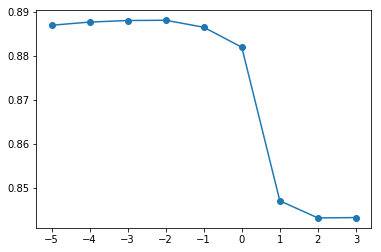

In [167]:
cvscore=[]
for a in range(-5,4):
    clf3=BernoulliNB(alpha=10**a)
    clf3.fit(X_1,y_1) # Using Train set of 90% data points
    scores = cross_val_score(clf3, X_1, y_1, cv=10, scoring='accuracy')
    cvscore.append(scores.mean())
    print("Accuracy score for alpha=10^{} is {}\n".format(a,scores.mean()*100))  
plt.plot(range(-5,4),cvscore,'-o')
plt.show()

In [168]:
clf3=BernoulliNB(alpha=10**-2)
clf3.fit(X_1,y_1)
y_pred=clf3.predict(X_test)
print(accuracy_score(y_test,y_pred))
confusion_matrix(y_test,y_pred)

0.886429787468


array([[ 3756,  1984],
       [ 2152, 28526]], dtype=int64)

In [169]:
tn, fp, fn, tp=confusion_matrix(y_test, y_pred).ravel()

tpr=tp/(tp+fn)
fpr=fp/(fp+tn)
tnr=tn/(tn+fp)
fnr=fn/(fn+tp)
print("TPR is {}\n FPR is {}\n TNR is {}\n FNR is {}".format(tpr*100,fpr*100,tnr*100,fnr*100))

TPR is 92.98520112132472
 FPR is 34.56445993031359
 TNR is 65.43554006968641
 FNR is 7.014798878675273


## Find Best Alpha using Grid Search

In [225]:
clf3=GridSearchCV(BernoulliNB(),tuned_parameters,cv=10,scoring=['accuracy','f1'],refit='f1')
clf3.fit(X_1,y_1)

GridSearchCV(cv=10, error_score='raise',
       estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit='f1', return_train_score='warn',
       scoring=['accuracy', 'f1'], verbose=0)

In [226]:
print(clf3.best_estimator_)
print(clf3.score(X_test,y_test))

BernoulliNB(alpha=0.001, binarize=0.0, class_prior=None, fit_prior=True)
0.931757032205


# Applying Naive Bayes on Word2vec

In [96]:
from gensim.models import Word2Vec
import gensim

In [97]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in data1['Text'].values:
    filtered_sentence=[]
    sent=remove_tags(sent)
    for w in sent.split():
        for cleaned_words in remove_punct(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [98]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=100, workers=4)    # Word2Vec Model

In [99]:
w2v_words = list(w2v_model.wv.vocab)
print(len(w2v_words))

34298


In [100]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [101]:
list_of_sent

[['this',
  'witty',
  'little',
  'book',
  'makes',
  'my',
  'son',
  'laugh',
  'at',
  'loud',
  'i',
  'recite',
  'it',
  'in',
  'the',
  'car',
  'as',
  'were',
  'driving',
  'along',
  'and',
  'he',
  'always',
  'can',
  'sing',
  'the',
  'refrain',
  'hes',
  'learned',
  'about',
  'whales',
  'india',
  'drooping',
  'i',
  'love',
  'all',
  'the',
  'new',
  'words',
  'this',
  'book',
  'introduces',
  'and',
  'the',
  'silliness',
  'of',
  'it',
  'all',
  'this',
  'is',
  'a',
  'classic',
  'book',
  'i',
  'am',
  'willing',
  'to',
  'bet',
  'my',
  'son',
  'will',
  'still',
  'be',
  'able',
  'to',
  'recite',
  'from',
  'memory',
  'when',
  'he',
  'is',
  'in',
  'college'],
 ['i',
  'can',
  'remember',
  'seeing',
  'the',
  'show',
  'when',
  'it',
  'aired',
  'on',
  'television',
  'years',
  'ago',
  'when',
  'i',
  'was',
  'a',
  'child',
  'my',
  'sister',
  'later',
  'bought',
  'me',
  'the',
  'lp',
  'which',
  'i',
  'have',
  '

In [102]:
print(len(sent_vectors))
sent_vectors[6]

364171


array([-0.225796  ,  0.42078897, -0.23452778,  1.16210927, -0.75630955,
       -0.05065186, -0.26677279, -0.4397273 , -0.03385498, -0.20539293,
       -0.21959465, -0.1623945 ,  0.22105213,  0.13344967,  0.1297588 ,
        0.14397525, -0.32871793, -0.51389999, -0.11627708,  0.12884786,
        0.56815826,  0.18402683,  0.1450861 ,  0.43535648,  0.72380622,
       -0.63795401,  0.19202598, -0.29387971, -0.00728617, -0.27203582,
        0.21867631, -0.49747842, -0.05207074, -0.29560183,  0.27960106,
        0.30974988,  0.02581915, -0.01042742,  0.16480055,  0.05336671,
        0.13026759,  0.32151499,  0.67869013, -0.18259811, -0.41514607,
        0.45189275, -0.15396323,  0.21504617, -0.53508309, -0.57939451,
        0.15967898,  0.64646107, -0.31652149,  0.16680893, -0.51441103,
        0.73651597, -0.08730378,  0.57212455,  0.2242436 ,  0.52958532,
        0.54285879, -0.14856815,  0.12755847, -0.47404809,  0.10950585,
       -0.41302928, -0.15938951, -0.24709679, -0.0238465 ,  0.31

In [231]:
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB

In [228]:
X_1,X_test,y_1,y_test=train_test_split(sent_vectors,y, random_state=0,test_size=0.1)

X_train,X_cv,y_train,y_cv=train_test_split(X_1,y_1,random_state=0,test_size=0.1)

In [229]:
clf4=GaussianNB()

clf4.fit(X_train,y_train)

y_pred=clf4.predict(X_test)

print(accuracy_score(y_test,y_pred))
confusion_matrix(y_test,y_pred)
fl_score()

0.775934977209


array([[ 4231,  1509],
       [ 6651, 24027]], dtype=int64)

In [175]:
tn, fp, fn, tp=confusion_matrix(y_test, y_pred).ravel()

tpr=tp/(tp+fn)
fpr=fp/(fp+tn)
tnr=tn/(tn+fp)
fnr=fn/(fn+tp)
print("TPR is {}\n FPR is {}\n TNR is {}\n FNR is {}".format(tpr*100,fpr*100,tnr*100,fnr*100))

TPR is 78.3199687072169
 FPR is 26.28919860627178
 TNR is 73.71080139372822
 FNR is 21.680031292783102
